In [32]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import os
import random
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [34]:
#!# normalize

# número de puntos de datos considerados para calcular la pérdida o actualizar pesos que se usan en cada iteración del entrenamiento del modelo.
BATCH_SIZE = 2#1
# número de iteraciones para entrenar el modelo
NUM_EPOCHS = 10#5

# dimensiones de la imagen
WIDTH = 704
HEIGHT = 520

# Si hacemos uso de transfer learning debemos cambiar el tamaño de las imágenes, permutarlas y normalizarlas (cada modelo preentrenado tiene sus ajustes propios)
# Hiperparámetros c:
#!# CUIDADO!HAY QUE CAMBIARLO
#- rgb vs greyscale https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2 <- modificar normalize y lo que haga falta a 1 canal.
# https://pytorch.org/vision/master/_modules/torchvision/models/detection/mask_rcnn.html
'''
While leveraging pre-trained models, it is mandatory to resize,
permute, and then normalize images (as appropriate for that pretrained model), where the images are first scaled to a value between
0 and 1 across the 3 channels and then normalized to a mean of
[0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225]
across the RGB channels. PAG 221.
'''
NORMALIZE = True # Si es True se normalizarán
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

# Hiperparámetros necesarios para entrenar el modelo:
MOMENTUM = 0.9 # para acelerar el aprendizaje y no quedaros en mínimo local 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005 # para que el modelo genralice mejor. Agrega un término de penalización a la función de coste que tiene el efecto de reducir los pesos durante la retropropagación.

# Mínimo valor para que un píxel sea considerado máscaara. Por convención el límite es 0.5.
cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}
mask_threshold = 0.5

# Tenemos que definir el dispositivo dónde almacenamos los objetos y donde se ejecuta la red (GPU o CPU) para agilizar el proceso de aprendizaje.
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [35]:
def split_data(data):
  '''
  creación de subconjuntos de datos en entrenamiento, validación y test y correspondientes dataframes.
  Para la correcta división de los datos hago uso de los quantiles de las anotaciones.

  devuelve: subconjuntos de datos en dataframes
  '''
  df_base = pd.read_csv(data)
  df_images = df_base.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()

  # Creación de dataframes para cada subconjunto de datos creados:
  df_images_total_train, df_images_test = train_test_split(df_images, 
                                                    stratify=df_images['cell_type'], 
                                                    test_size=0.15,
                                                    random_state=1234)
  df_images_train, df_images_val = train_test_split(df_images, 
                                                    stratify=df_images['cell_type'], 
                                                    test_size=0.1,
                                                    random_state=1234)

  df_train = df_base[df_base['id'].isin(df_images_train['id'])]
  df_val = df_base[df_base['id'].isin(df_images_val['id'])]
  df_test = df_base[df_base['id'].isin(df_images_test['id'])]

  return df_train, df_val, df_test, df_images_train, df_images_val, df_images_test
  
def rle_decode(mask_rle, shape, color=1):
    '''
    Función para agilizar la tarea de segmentación de instancia con el método Run-Length encoding(RLE): 
    una forma de comprimir datos sin pérdida.
    - Los datos se comprimen:
      las secuencias del mismo dato se almacenan como el dato y su frecuencia.
      En este caso se codifica la máscara (0 para el fondo y 1 para el objecto) y se preservan los lugares de valor 1.

    - Los datos se descomprimen.

    Argumentos:
    - mask_rle: run-length as string formated (start length)
    - shape: (height, width, channels) of array to return
    - color: color for the mask
    
    Returns numpy array (mask)
    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2])) # matriz de inicio que contiene una lista de índices de inicio
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)

def rle_encoding(x):
    '''
    Función para agilizar la tarea de segmentación de instancia con el método Run-Length encoding(RLE): 
    una forma de comprimir datos sin pérdida.
    - Los datos se comprimen:
      las secuencias del mismo dato se almacenan como el dato y su frecuencia.
      En este caso se codifica la máscara (0 para el fondo y 1 para el objecto) y se preservan los lugares de valor 1.

    - Los datos se descomprimen.

    Argumentos:
    - This function convert again convert Mask into run length encoding
    '''
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [21]:
class CellDataset(Dataset):
    '''
    Esta clase deriva de la clase importada en pytorch: Dataset (por lo que hay que definir init,  getitem y len).
    Esta clase almacena los datos para poder obtener un punto de datos a la vez.

    argumentos:
    - image_dir: ruta de las imágenes
    - df: dataframe
    - transform: si es el conjunto de entrenamiento aplicamos la función get_transform
    '''
    def __init__(self, image_dir, df, transforms=None):
        self.transforms = transforms # aplicamos la función get_transform
        self.image_dir = image_dir 
        self.df = df
        self.dfdict = self.df.to_dict('index')

    def __getitem__(self, idx):
        # idx hace referencia al índice de la fila que se va a obtener del conjunto de datos.
        df_dict = self.dfdict[idx]
        img_path = os.path.join(self.image_dir, df_dict['id'] + '.png')
        
        # cargamos la imagen
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        # creamos los cuadros delimitadores y máscaras para cada imagen
        boxes = []
        masks = np.zeros((len(df_dict['annotation']), df_dict['height'], df_dict['width']), dtype=np.uint8)
        for i, annot in enumerate(df_dict['annotation']):
          rle = rle_decode(annot, (df_dict['height'], df_dict['width']))

          mask = np.array(rle) > 0

          masks[i, :, :] = mask

          boxes.append(get_box(mask))
        
        # Mask R-CNN requiere un target donde almacenemos los datos de cada imagen en un diccionario, convertimos a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = [int(df_dict["cell_type"]) for _ in range(len(df_dict['annotation']))]
        target = {
            'boxes': boxes,
            'labels': torch.as_tensor(labels, dtype=torch.int64),
            'masks': torch.as_tensor(masks, dtype=torch.uint8),
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(df_dict['annotation']),), dtype=torch.int64)
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
      # número de puntos de datos
      return len(self.dfdict)

# Transformaciones horizontal y vertical para hacer data augmentation
# Normalización de las imágenes (mean y std de Resnet) a través del hiperparámetro NORMALIZE (True o False)
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    
def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation para el entrenamiento
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [22]:
def get_data(data_path, df, transform_train, batch_size):
  '''
  argumentos:
  - data_path: ruta de acceso a imágenes
  - df: dataframe sobre el que crear una instancia de la clase CellDatast
  - transform_train: True o False si queremos o no crear data augmentation en los datos de entrenamiento
  - batch_size: número de puntos de datos que agruparemos
  - resize: ajuste de las dimensiones de las imágenes

  devuelve: instancia de clase CellDataset y DataLoader

  objetivo: cargar y procesar los datos e imágenes como fuente de entrada correcta para poder ser entrenados
  '''
  # modificamos el dataframe para poder instanciarlo como clase CellDataset
  new_df = df.groupby(["id", "cell_type","width","height"])['annotation'].agg(lambda x: list(x)).reset_index()
  new_df['cell_type'] = new_df['cell_type'].apply(lambda x: int(cell_type_dict[x]))

  ds = CellDataset(data_path, new_df, transforms=get_transform(train=transform_train))
  # La clase DataLoader nos ayuda a preparar los datos para la red neuronal definiendo el dataset con el que trabajar, el batch, si la muestra es aleatoria, etc.
  dl = DataLoader(ds, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=lambda x: tuple(zip(*x)))
  return dl, ds

In [23]:
def get_box(mask):
  '''
  obtenemos el cuadro delimitador de una máscara
  '''
  pos = np.where(mask) # encontramos la posición dnode mask=1
  xmin = np.min(pos[1]) # la mínima posición nos dará las coordenadas mínimas
  xmax = np.max(pos[1]) # la máxima posición nos dará las coordenadas máximas
  ymin = np.min(pos[0])
  ymax = np.max(pos[0])
  return [xmin, ymin, xmax, ymax]

In [36]:
BATCH_SIZE = 2
#Initialize the model, loss, optimizer, and DataLoaders:
# Get data
df_train, df_val, df_test, df_images_train, df_images_val, df_images_test = split_data(f"drive/MyDrive/sartorius-cell-instance-segmentation/train.csv")

data_path = f"drive/MyDrive/sartorius-cell-instance-segmentation/train"
dl_train, ds_train = get_data(data_path, df_train, transform_train=True, batch_size=BATCH_SIZE)
dl_val, ds_val = get_data(data_path, df_val, transform_train=False, batch_size=BATCH_SIZE)

ds_test = get_data(data_path, df_test, transform_train=False, batch_size=BATCH_SIZE)[1]

In [25]:
#!# Renombrar variables
def remove_overlapping_pixels(mask, other_masks):
  '''
  argumentos:
  - mask: máscara
  - other_masks: lista de máscaras 

  función: elimina máscaras iguales. 
  Si una máscara de other_masks es igual que mask, la eliminamos

  devuelve: la máscara eliminada (todo Falses) o la máscara inicial (mask)
  '''
  for other_mask in other_masks:
    if np.sum(np.logical_and(mask, other_mask)) > 0:
      mask[np.logical_and(mask, other_mask)] = 0
  return mask

def get_filtered_masks(pred):
    """
    argumento:
    - pred: resultado de predicción

    función: eliminar las máscaras iguales predichas en una imagen y filtrar los píxeles 
    con menor confianza de ser predichos correctamente.

    devuelve: las máscaras filtradas de la predicción
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):

        # obtengo la probabilidad de la célula de ser predicha correctamente y su clasificación
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > 0.5:
            mask = mask.cpu().numpy().squeeze() #retira el eje de longitud 1
            # elimino los píxeles predichos con menor confianza de ser correctos:
            binary_mask = mask > mask_threshold
            # anulo la máscara si ya está en use_masks:
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks) 
            use_masks.append(binary_mask)

    return use_masks

def combine_masks(masks, mask_threshold):
    """
    argumentos:
    - masks: máscara
    - mask_threshold: límite inferior para que el píxel se considere predicción correcta

    función: agrupo todas las máscaras en una sola para visualizarla posteriormente

    devuelve: máscara combinada de toda la imagen con todas las células
    """
    maskimg = np.zeros((HEIGHT, WIDTH))
    for m, mask in enumerate(masks,1):
      # si el píxel es mayor que el límite propuesto lo añadimos a la máscara
      maskimg[mask>mask_threshold] = m
    return maskimg

# EDA

**¿Cuántas imágenes hay y qué dimension tienen?**

In [37]:
print(f'Number of unique images: {df_train.id.nunique()}')
print(f'Do all the images have a width of 704: {(df_train["width"]==704).all() == (df_val["width"]==704).all() == (df_test["width"]==704).all()}')
print(f'Do all the images have a height of 520: {(df_train["height"]==520).all() == (df_val["height"]==520).all() == (df_test["height"]==520).all()}')

Number of unique images: 545
Do all the images have a width of 704: True
Do all the images have a height of 520: True


**¿En cada imagen cuántos tipos de célula hay?**

In [38]:
if len(df_train.groupby(['id','cell_type']).agg({'annotation':'count'})) == \
  len(df_train.groupby(['id']).agg({'annotation':'count'})):
  print('Each image has just one cell type')
else:
  print('Each image can have more than one cell type')

Each image has just one cell type


**¿Cuántas imágenes con cada tipo de célula hay?**

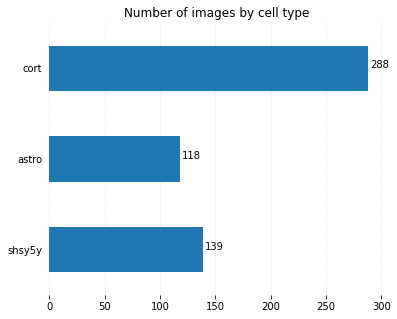

In [39]:
cells_per_image = pd.DataFrame()
for e,i in enumerate(df_train.cell_type.unique()):
  df_ = df_train[df_train['cell_type'] == i]
  cells_per_image[i] = pd.Series(df_['id'].value_counts().describe())
cells_per_image['all_cells'] = pd.Series(df_train['id'].value_counts().describe())

fig, ax = plt.subplots(figsize =(6, 5))
plt.title('Number of images by cell type')
round(cells_per_image.T['count'][:-1]).plot.barh()
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+2, i.get_y()+0.25,
             str((int(i.get_width()))),
             fontsize = 10,
             color ='black')
# Remove y Ticks
ax.yaxis.set_ticks_position('none')
# Add x, y gridlines
ax.xaxis.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

In [40]:
round(cells_per_image.T['count'][:-1].div(cells_per_image['all_cells'].T['count']),2)

shsy5y    0.26
astro     0.22
cort      0.53
Name: count, dtype: float64

Más de la mitad de las imágenes son de tipo de célula *cort* mientras que la otra mitad se divide, casi a la misma proporción, entre *shy5yy* y *astro*.

**¿Cuántas células hay por imagen?**

In [41]:
print('Células por imagen según su tipo:')
cells_per_image.T

Células por imagen según su tipo:


,count,mean,std,min,25%,50%,75%,max
shsy5y,139.0,338.553957,149.930765,49.0,239.50,324.0,429.0,790.0
astro,118.0,80.313559,66.683805,5.0,50.00,70.5,98.5,594.0
cort,288.0,33.711806,16.416304,4.0,23.75,30.5,39.0,108.0
all_cells,545.0,121.550459,152.600539,4.0,28.00,46.0,142.0,790.0


El número de células que aparece en cada imagen puede variar mucho: desde 4 a 790 células.

Las células que aparecen en cada imagen varían también según el tipo de célula que sean.

La célula *shsy5y* aparece entre 239 y 429 veces por imagen en su rango intercuartílico.

La célula *astro* aparece entre 50 y 98 veces por imagen en su rango intercuartílico.

La célula *cort* aparece entre 23 y 39 veces por imagen en su rango intercuartílico.

**¿Cómo es la morfología de cada tipo de célula?**

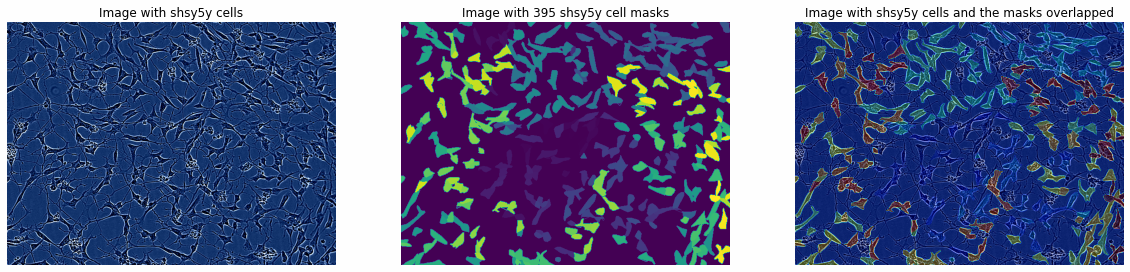

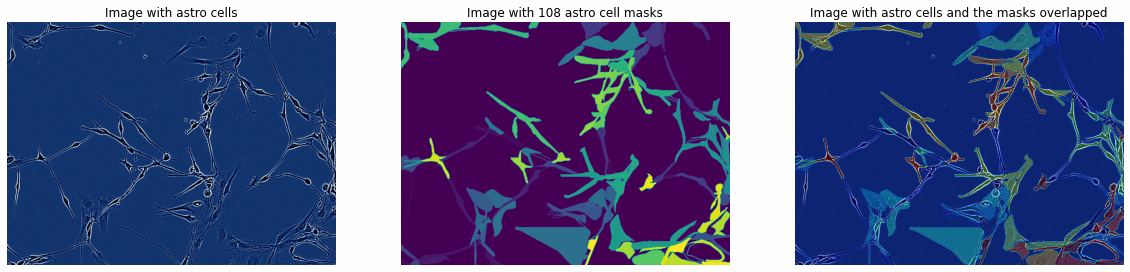

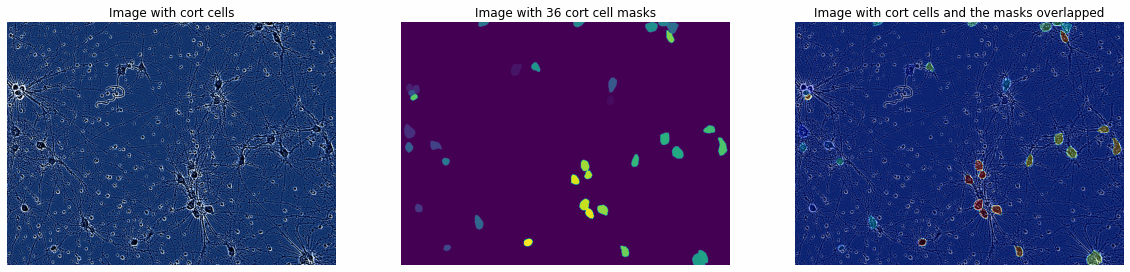

In [42]:
cells = []
for sample in range(len(ds_train)):
  img, targets = ds_train[sample]
  img = np.clip(img, 0, 1)
  l = np.unique(targets["labels"])
  pos = list(cell_type_dict.values()).index(l)
  cell_name = list(cell_type_dict.keys())[pos]
  ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
  if l not in cells:
    cells.append(l)
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"Image with {cell_name} cells", fontsize=12)
    ax[0].axis("off")

    masks = combine_masks(targets['masks'], 0.5)
    ax[1].imshow(masks)
    ax[1].set_title(f"Image with {len(targets['masks'])} {cell_name} cell masks")
    ax[1].axis("off")

    ax[2].imshow(img.numpy().transpose((1,2,0)))
    ax[2].imshow(masks, cmap='jet', alpha=0.3)
    ax[2].set_title(f"Image with {cell_name} cells and the masks overlapped")
    ax[2].axis("off")
  if len(cells) == 3:
    break

Cada tipo de célula tiene sus propias propiedades morfológicas únicas.

Las céluas *astro* son las más grandes en forma. Cubren mucho espacio en las máscaras.

Las células *cort* son las más pequeñas y tienen forma de círculo. No cubren mucho espacio en las máscaras.

Las células *shsy5y* son un poco más grandes, alargadas y más abundantes que las *cort*. Cubren más espacio que las células corticales.

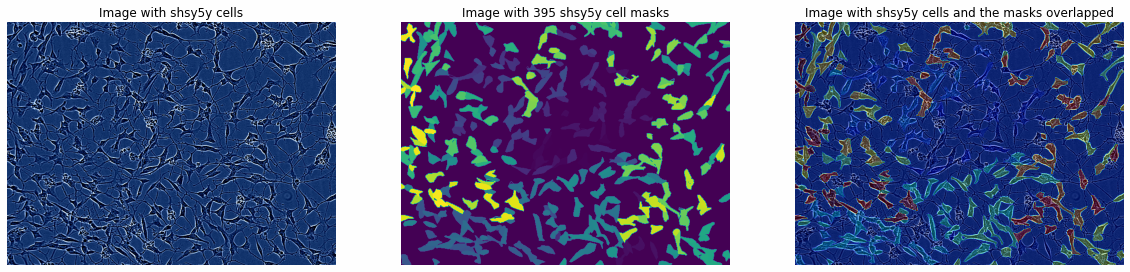

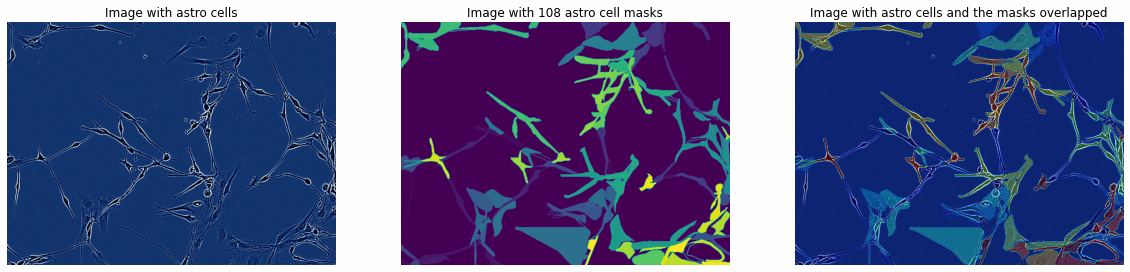

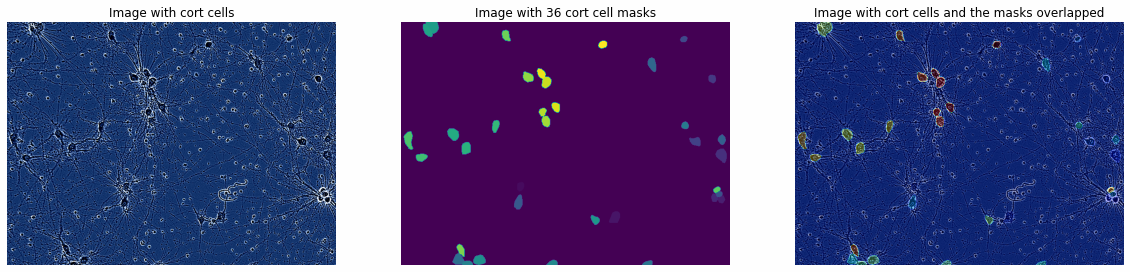

In [43]:
cells = []
for sample in range(len(ds_val)):
  img, targets = ds_train[sample]
  img = np.clip(img, 0, 1)
  l = np.unique(targets["labels"])
  pos = list(cell_type_dict.values()).index(l)
  cell_name = list(cell_type_dict.keys())[pos]
  ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
  if l not in cells:
    cells.append(l)
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"Image with {cell_name} cells", fontsize=12)
    ax[0].axis("off")

    masks = combine_masks(targets['masks'], 0.5)
    ax[1].imshow(masks)
    ax[1].set_title(f"Image with {len(targets['masks'])} {cell_name} cell masks")
    ax[1].axis("off")

    ax[2].imshow(img.numpy().transpose((1,2,0)))
    ax[2].imshow(masks, cmap='jet', alpha=0.3)
    ax[2].set_title(f"Image with {cell_name} cells and the masks overlapped")
    ax[2].axis("off")
  if len(cells) == 3:
    break

**Proporciones de células y anotaciones en los distintos conjuntos de datos**

In [44]:
train_ = df_train.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()
train_.groupby(["cell_type"]).describe()

annotation                                                      \
               count        mean         std   min     25%    50%    75%   
cell_type                                                                  
astro          118.0   80.313559   66.683805   5.0   50.00   70.5   98.5   
cort           288.0   33.711806   16.416304   4.0   23.75   30.5   39.0   
shsy5y         139.0  338.553957  149.930765  49.0  239.50  324.0  429.0   

                  
             max  
cell_type         
astro      594.0  
cort       108.0  
shsy5y     790.0

In [45]:
val_ = df_val.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()
val_.groupby(["cell_type"]).describe()

annotation                                                       \
               count        mean         std   min     25%    50%     75%   
cell_type                                                                   
astro           13.0   80.384615   34.623062  18.0   63.00   86.0  105.00   
cort            32.0   33.375000   17.470251  11.0   20.00   28.5   39.25   
shsy5y          16.0  326.687500  151.035854  58.0  223.75  335.5  428.75   

                  
             max  
cell_type         
astro      133.0  
cort        84.0  
shsy5y     571.0

In [46]:
test_ = df_test.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()
test_.groupby(["cell_type"]).describe()

annotation                                                      \
               count        mean         std   min    25%    50%     75%   
cell_type                                                                  
astro           20.0   69.050000   34.966864  18.0   32.0   79.0   96.75   
cort            48.0   33.958333   16.538747  11.0   20.0   30.5   41.00   
shsy5y          23.0  339.652174  149.881653  55.0  234.5  402.0  450.50   

                  
             max  
cell_type         
astro      133.0  
cort        84.0  
shsy5y     571.0

Parece que todos los conjuntos de datos guardan una misma proporción entre imágenes según tipo de células y anotaciones por imagen y tipo de célula.

A primera vista los datos de todos los conjuntos deberían de ser representativos del conjunto de datos de entrenamiento.